# Twitter Gender Predictor

#### Marta Kołbuk, Klaudia Jarosz, Dasha Hubernatorova

The dataset presented in this task was originally used to train a CrowdFlower AI gender predictor. Contributors were asked to simply view a Twitter profile and judge whether the user was a male, a female, or a brand (non-individual). The dataset contains 20,000 rows, each with a user name, a random tweet, account profile and image, location, and even link and sidebar color.

With it we will try to answer the following questions:
- how well do words in tweets and profiles predict user gender?
- what are the words that strongly predict male or female gender?
- how well do stylistic factors (like link color and sidebar color) predict user gender?

### Imports

Firstly, we need to import all necessary tools.

In [1]:
import csv
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # function for encoding categories
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier


### Reading the data from the file

Now we need to import the data into our .ipynb file and view it in order to find out what kind of data we are dealing with.

In [2]:
# text is encoded in utf-8 now, but if we would like to use original text file, we have to add encoding parameter
# d = pd.read_csv('data/gender-classifier-DFE-791531.csv', encoding='latin_1')
genblen = pd.read_csv('data/gender-classifier-DFE-791531.csv')
genblen.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


Some of the cells are filled with NaN values. Let us removed them.

In [3]:
gender_confidence = genblen['gender:confidence'][np.where(np.invert(np.isnan(genblen['gender:confidence'])))[0]]
gender_confident = genblen[genblen['gender:confidence']==1]

Let's have a look at the gender distribution.

In [4]:
gender_counts= gender_confident['gender'].value_counts()
gender_counts/sum(gender_counts)

female     0.385394
male       0.334123
brand      0.271722
unknown    0.008761
Name: gender, dtype: float64

Data normalisation- choosing border value for numeric type

In [5]:
of_value = []
def make_of_value(data):
    if not len(of_value) == 3:
        mean = data.fav_number.mean()
        of_value.append(mean)
    data.fav_number = data.fav_number.map(lambda x: x < of_value[0])

    if not len(of_value) == 3:
        tweet_count_mean = data.tweet_count.median()
        of_value.append(tweet_count_mean)
    data.tweet_count = data.tweet_count.map(lambda x: x < of_value[1])

    if not len(of_value) == 3:
        retweet_count_mean = data.retweet_count.median()
        of_value.append(retweet_count_mean)
    data.retweet_count = data.retweet_count.map(lambda x: x < of_value[2])
    return data

Dealing with missing data and choosing relevant columns

In [6]:
genblen.gender.fillna('unknown', inplace=True)
genblen.description.fillna('', inplace=True)
genblen = genblen.query('gender != "unknown"')#.query('gender != "brand"')
genblen = genblen[['gender', 'text', 'name', 'retweet_count', 'description', 'fav_number', 'tweet_count']]

Vecotizers- functions translating words or rather ngrams to vectors of numbers

In [7]:
genblen_test = TfidfVectorizer(
    analyzer='word', lowercase=True, ngram_range=(1, 2), use_idf=False)

genblen_test_name = TfidfVectorizer(
    analyzer='char', lowercase=True, ngram_range=(1, 2), use_idf=False)

genblen_test_description = TfidfVectorizer(
    analyzer='word', lowercase=True, ngram_range=(1, 2), use_idf=False)


now we split data into training and test sets

In [8]:
x_train, x_test, y_train, y_test = train_test_split(genblen, genblen.gender, test_size=0.3, random_state=0)

Creating training and test sets

In [9]:
x_train = make_of_value(x_train)
x_test = make_of_value(x_test)

C:\Users\mkolbuk\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [10]:
genblen_test.fit(x_train.text)
genblen_test_name.fit(x_train.name)
genblen_test_description.fit(x_train.description)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=False,
        vocabulary=None)

Stacking all values together

In [11]:
def get_features(x):
    return hstack([
        genblen_test_description.transform(x.description),
        genblen_test.transform(x.text),
        genblen_test_name.transform(x.name),
        csr_matrix(x.retweet_count.values).T,
        csr_matrix(x.fav_number.values).T,
        csr_matrix(x.tweet_count.values).T
    ])

Function that prepares column names for our model

In [12]:
def get_features_names():
    return genblen_test_description.get_feature_names() \
            + genblen_test.get_feature_names() + genblen_test_name.get_feature_names() + ['retweet_count', 'fav_number', 'tweet_count']

### SVM

In [13]:
features_train = get_features(x_train)
model = OneVsRestClassifier(LinearSVC(verbose=True, random_state=0))
model.fit(features_train, y_train)
features_test = get_features(x_test)
pred = model.predict(features_test)

[LibLinear][LibLinear][LibLinear]

### How well do words in tweets and profiles predict user gender?

In [14]:
print(classification_report(y_pred=pred, y_true=y_test))
print(confusion_matrix(y_pred=pred, y_true=y_test))

             precision    recall  f1-score   support

      brand       0.75      0.76      0.75      1767
     female       0.66      0.70      0.68      2001
       male       0.62      0.57      0.59      1883

avg / total       0.67      0.67      0.67      5651

[[1339  167  261]
 [ 198 1393  410]
 [ 244  563 1076]]


We are very pleased with the results, because the prediction percentage is very high. It is not ideal, nevertheless, for detection and analysis of words that is a terrific score. 

### Highest male coefficients

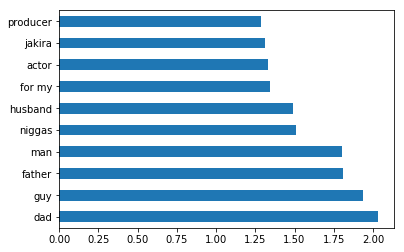

In [15]:
(pd.Series(model.coef_[2], index = get_features_names())
        .sort_values(ascending=False)
        .head(10)
        .plot.barh())

### Highest female coefficients

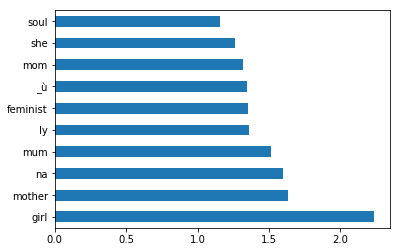

In [16]:
(pd.Series(model.coef_[1], index = get_features_names())
        .sort_values(ascending=False)
        .head(10)
        .plot.barh())

### Highest brand coefficients

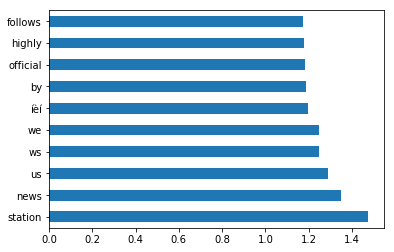

In [17]:
(pd.Series(model.coef_[0], index = get_features_names())
        .sort_values(ascending=False)
        .head(10)
        .plot.barh())

Wow, we are impressed how our classifier chose the words that match various genders the most. Of course, some may lack sense, but it is mainly because we analysed not only direct text from tweets, but also profile descriptions and retweets.